## RT-DETRv2 Fire-Smoke Detection (Hyperparameter)

In [1]:
# 필요한 라이브러리 설치
!pip install -q ultralytics gdown

## 1. 환경 설정 및 라이브러리 임포트

In [1]:
import os, glob, gdown, zipfile
import random
import math
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file_id = '1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz'
zip_path = 'fire_smoke_detection.zip'

# Download ZIP into current directory
gdown.download(f'https://drive.google.com/uc?id={file_id}', zip_path, quiet=False)

# Extract into current directory
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall('.')

print("Dataset downloaded and extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz
From (redirected): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz&confirm=t&uuid=5f8320b7-fe79-4695-b9f8-e5359d74b1f1
To: /fire_smoke_detection.zip
100%|██████████| 3.07G/3.07G [00:35<00:00, 85.9MB/s]


Dataset downloaded and extracted.


In [3]:
# 시각화 유틸 함수: 라벨 있는 이미지들에서 3x3 그리드로 예측 bbox 표시

def visualize_grid(model, image_dir: str, label_dir: str, rows: int = 3, cols: int = 3):
    if not os.path.exists(image_dir):
        raise RuntimeError(f'이미지 디렉토리를 찾을 수 없습니다: {image_dir}')
    if not os.path.exists(label_dir):
        raise RuntimeError(f'라벨 디렉토리를 찾을 수 없습니다: {label_dir}')

    img_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    label_backed = []
    for f in img_files:
        stem = os.path.splitext(f)[0]
        if os.path.exists(os.path.join(label_dir, stem + '.txt')):
            label_backed.append(f)

    if len(label_backed) == 0:
        raise RuntimeError('라벨 파일이 있는 이미지를 찾지 못했습니다.')

    sample_count = min(rows * cols, len(label_backed))
    sample_imgs = random.sample(label_backed, sample_count)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for idx, f in enumerate(sample_imgs):
        img_path = os.path.join(image_dir, f)
        infer_results = model(img_path, verbose=False)
        r = infer_results[0]
        plotted = r.plot()
        axes[idx].imshow(plotted)
        axes[idx].axis('off')
        axes[idx].set_title(f, fontsize=8)

    for k in range(sample_count, rows * cols):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
from ultralytics import RTDETR
import torch

# GPU 확인
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA Available: True
GPU: NVIDIA A100-PCIE-40GB
CUDA Version: 11.8


## 2. 데이터 경로 및 설정 확인

In [5]:
# 데이터셋 경로 확인
data_yaml = r'fire_smoke_detection/data.yaml'

# 파일 존재 확인
if os.path.exists(data_yaml):
    print(f"Data Configuration Found: {data_yaml}")
    
    # data.yaml 내용 확인
    with open(data_yaml, 'r') as f:
        print("\ndata.yaml 내용:")
        print(f.read())
else:
    print(f"데이터 설정 파일을 찾을 수 없음: {data_yaml}")

Data Configuration Found: fire_smoke_detection/data.yaml

data.yaml 내용:
# 로컬 환경용 경로 설정 (YAML 파일 기준 상대 경로)
train: data/train/images
val: data/val/images  
test: data/test/images

# Classes
names: ['smoke', 'fire']  # Replace with your actual class names

# Counts
nc: 2  # number of classes
train_count: 14122
val_count: 3099
test_count: 4306



In [6]:
# hyp.yaml 경로 설정
hyp_path = r'fire_smoke_detection/hyp.yaml'

# 파일 존재 확인
if os.path.exists(hyp_path):
    print(f"Hyperparameter Configuration Found: {hyp_path}")
    
    # hyp.yaml 내용 확인
    with open(hyp_path, 'r') as f:
        print("\nhyp.yaml 내용:")
        print(f.read())
else:
    print(f"하이퍼파라미터 설정 파일을 찾을 수 없음: {hyp_path}")

Hyperparameter Configuration Found: fire_smoke_detection/hyp.yaml

hyp.yaml 내용:

# RT-DETR Fire-Smoke Detection 최적 하이퍼파라미터
# YOLOv11n 학습 결과 분석 기반 (mAP50: 0.7615 → 0.80+ 목표)

# ========== 학습률 설정 ==========
lr0: 0.002              # 초기 학습률 (안정적 수렴)
lrf: 0.01               # 최종 학습률 비율
momentum: 0.937         # SGD momentum
weight_decay: 0.0005    # L2 정규화 (과적합 방지)
warmup_epochs: 5.0      # Warm-up 기간
warmup_momentum: 0.8
warmup_bias_lr: 0.1

# ========== Data Augmentation ==========
# Mosaic & Mix
mosaic: 1.0             # Mosaic augmentation (0.0-1.0)
mixup: 0.15             # MixUp augmentation (클래스 경계 학습)
copy_paste: 0.3         # Copy-Paste (작은 화재/연기 객체 증강)

# 기하학적 변환
degrees: 10.0           # 회전 각도 (-deg ~ +deg) - 카메라 각도 변화
translate: 0.2          # 이동 (0.0-1.0) - 객체 위치 다양화
scale: 0.7              # 크기 변화 (gain) - 화재 크기 다양성
shear: 0.0              # 전단 변환 (화재에는 불필요)
perspective: 0.0        # 원근 변환 (화재에는 불필요)
flipud: 0.0             # 상하 반전 (화재는 아래, 연기는 위 - 비활성화)
fliplr: 0.5          

## 3. RT-DETRv2 모델 로드

In [7]:
model = RTDETR('rtdetr-l.pt')

## 4. 하이퍼파라미터 학습

In [8]:
default_batch = 32        # A100 40GB: 48-64
num_workers = 8           # Linux dataloader workers

# hyp.yaml 적용 학습 실행
results_hyp = model.train(
    data=data_yaml,
    cfg=hyp_path,           # 하이퍼파라미터 YAML 적용
    epochs=50,
    imgsz=640,
    batch=default_batch,
    device=0,
    workers=num_workers,
    cache=False,
    amp=True,
    patience=10,
    project='rtdetr_fire_smoke_hyp',
    name='rtdetrv2_hyp',    # 결과를 기본 학습과 구분
    exist_ok=True,
    verbose=True,
)

print("\n Hyperparameter training complete.")

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=fire_smoke_detection/hyp.yaml, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire_smoke_detection/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetrv2_hyp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

[W1129 16:31:07.944666294 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


rt-detr-l summary: 457 layers, 32,810,186 parameters, 32,810,186 gradients, 108.0 GFLOPs

Transferred 926/941 items from pretrained weights
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2623.2±1314.0 MB/s, size: 141.2 KB)
train: Scanning /fire_smoke_detection/data/train/labels... 14122 images, 6458 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14122/14122 1.3Kit/s 11.1s0.1s
train: New cache created: /fire_smoke_detection/data/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1111.9±785.9 MB/s, size: 59.6 KB)
val: Scanning /fire_smoke_detection/data/val/labels... 3099 images, 1375 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 1.1Kit/s 2.7s0.1ss
val: New cache created: /fire_smoke_detection/data/val/labels.cache
Plotting labels to /rtdetr_fire_smoke_hyp/rtdetrv2_hyp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimize

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/50      24.3G      1.033      1.622     0.6657         19        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:57<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 13.0s0.3s
                   all       3099       3932       0.49      0.481      0.417       0.19

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50      24.3G     0.6784     0.7643     0.3527        112        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/50      24.3G     0.6707     0.7427     0.3417         35        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:56<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.641      0.546      0.587      0.284

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      24.5G     0.5219     0.8035     0.2589         76        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/50      24.5G     0.7007      0.685     0.3263         29        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.654      0.584      0.637      0.309

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      24.1G     0.6729     0.8219     0.3265         67        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/50      24.1G     0.7501     0.6503     0.3283         29        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.669      0.524      0.579      0.264

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50        24G     0.8544     0.5809     0.3047         63        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/50        24G     0.8129     0.6268     0.3478         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.583      0.449      0.477      0.218

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      24.2G     0.6729     0.6571     0.2481         91        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/50      24.2G     0.8371     0.6235     0.3549         35        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.631      0.523      0.563      0.263

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      24.2G     0.9591     0.6342      0.317         91        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/50      24.2G     0.8164     0.6259     0.3454         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.662      0.595      0.627      0.303

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50      24.1G     0.7547     0.5896     0.2641         74        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/50      24.1G     0.7915     0.6165     0.3338         27        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.682      0.568      0.634      0.297

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      24.1G     0.7906     0.6279     0.3098         68        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/50      24.1G     0.7733     0.6164     0.3266         43        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.701      0.601       0.65       0.29

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      24.1G     0.5957     0.7339     0.4259         59        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/50      24.1G     0.7749     0.6039     0.3253         25        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.699      0.608      0.663      0.309

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      23.8G     0.7549     0.5447     0.2631        107        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/50      23.8G     0.7444     0.6101     0.3126         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.713      0.623      0.685       0.34

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      24.1G     0.8404     0.5934     0.4152         51        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/50      24.1G     0.7583     0.6088     0.3141         24        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.718      0.592      0.658      0.312

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      24.2G     0.6482     0.5721     0.2571         83        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/50      24.2G     0.7287     0.6019     0.3128         17        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:53<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.71      0.621       0.68       0.32

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      23.9G     0.7823      0.559     0.3076        109        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/50      23.9G     0.7332     0.5957     0.3103         15        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.726      0.639      0.703      0.346

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      24.2G     0.7058     0.5789     0.2506        102        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/50      24.2G     0.7198     0.6016     0.2963         38        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.728      0.629      0.686      0.328

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50      23.9G     0.6976     0.5441      0.259         85        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/50      23.9G     0.7048     0.5995     0.2995         21        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.72      0.634      0.697      0.323

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      24.2G     0.7135     0.5342     0.2506         82        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/50      24.2G     0.7108     0.5895     0.2966         25        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.718      0.672      0.719      0.349

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      23.9G     0.7276     0.5666     0.2331         88        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/50      23.9G     0.6842      0.605     0.2869         32        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.728      0.658      0.723      0.351

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50      23.8G     0.8657     0.4547     0.2791         71        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/50      23.8G     0.6915     0.5895     0.2896         26        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.741      0.661      0.733      0.359

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      24.1G     0.7476     0.5784     0.2657        109        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/50      24.1G     0.6753     0.5888     0.2858         30        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.742      0.661      0.736      0.351

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      23.9G     0.8118     0.5435      0.215        103        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      21/50      23.9G     0.6713     0.5896     0.2823         43        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.739      0.651      0.722      0.343

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      23.9G     0.6281     0.5568     0.2433        105        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      22/50      23.9G     0.6578     0.5932     0.2816         37        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932       0.72      0.661      0.724      0.348

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      24.1G     0.7605     0.5705      0.239         94        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      23/50      24.1G     0.6607      0.593     0.2813         40        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.742      0.684      0.748      0.377

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      24.1G     0.5353     0.7042     0.3217         64        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      24/50      24.1G     0.6543     0.5867     0.2782         25        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932       0.74      0.666      0.729      0.356

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50        24G     0.7728     0.5813     0.3175         76        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/50        24G     0.6452     0.5861     0.2748         24        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.747      0.692      0.746      0.365

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      24.1G     0.7207     0.5632     0.2425         53        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      26/50      24.1G     0.6298     0.5856     0.2709         22        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.738      0.701      0.755      0.379

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50        24G     0.6749     0.5385      0.233        122        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      27/50        24G     0.6309      0.588     0.2712         18        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.4s0.3s
                   all       3099       3932      0.756      0.693      0.762      0.382

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50      24.1G     0.8393     0.5288     0.2736         91        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      28/50      24.1G     0.6138      0.579     0.2678         20        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.739        0.7      0.757      0.375

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      24.1G     0.5234     0.5593     0.2784         67        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      29/50      24.1G     0.6248     0.5808     0.2692         12        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.4s0.3s
                   all       3099       3932      0.748      0.703      0.755      0.377

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      24.1G     0.4984     0.6171     0.2556         77        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      30/50      24.1G      0.634     0.5767     0.2764         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.3s0.3s
                   all       3099       3932      0.744      0.698      0.754      0.373
Closing dataloader mosaic

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      24.3G     0.7258     0.5586     0.3229         26        640: 0% ──────────── 0/442  1.0s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      31/50      24.3G     0.6076     0.5551     0.2984         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.4s0.3s
                   all       3099       3932      0.733      0.705       0.76      0.393

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50      24.2G     0.6557     0.5474     0.3019         33        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      32/50      24.3G     0.5833     0.5556      0.295          7        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.745        0.7      0.756      0.394

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      24.2G     0.6351     0.5795     0.3316         28        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      33/50      24.3G      0.565     0.5481     0.2895          9        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932       0.76      0.697      0.761      0.387

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      24.3G     0.3714     0.5336     0.2443         19        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      34/50      24.3G     0.5648     0.5291     0.2823         24        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.758      0.699      0.768      0.397

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      24.1G     0.6001     0.5249     0.2344         39        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/50      24.1G     0.5449     0.5215     0.2739         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.764      0.708      0.775      0.402

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      24.3G     0.3839     0.4821     0.2692         37        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      36/50      24.3G     0.5316     0.5102       0.27          7        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.4s0.3s
                   all       3099       3932       0.75      0.736       0.78      0.405

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      24.3G     0.6262     0.5285     0.2757         21        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      37/50      24.3G     0.5093     0.5093     0.2617          9        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.752      0.728      0.783      0.413

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      24.1G     0.4667     0.4876     0.2035         38        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      38/50      24.1G     0.4993     0.5036     0.2546         12        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.762      0.741      0.784      0.411

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      24.2G     0.5383     0.5082     0.2549         50        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      39/50      24.2G     0.4983     0.4966     0.2541         11        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:48<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 4.0it/s 12.4s0.3s
                   all       3099       3932      0.778      0.727      0.787      0.417

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      24.1G     0.5529     0.4576     0.1831         26        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      40/50      24.1G     0.4736      0.492     0.2458         14        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.782       0.73      0.788      0.418

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      23.8G     0.4655     0.4923     0.1905         66        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      41/50      23.8G     0.4699     0.4873     0.2475          8        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.787      0.732      0.794      0.422

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      24.3G     0.4217     0.5031     0.2389         33        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      42/50      24.3G     0.4652     0.4801     0.2429          8        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.5s0.3s
                   all       3099       3932      0.777      0.746      0.795      0.423

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      24.3G     0.4142     0.4618     0.2414         29        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/50      24.3G     0.4532     0.4763     0.2365          8        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.788      0.741      0.797      0.431

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50        24G     0.4645     0.4545     0.1967         58        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      44/50        24G     0.4697      0.467     0.2406         10        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.4s0.3s
                   all       3099       3932      0.791      0.742      0.798      0.429

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50      24.2G     0.4939     0.4388     0.1228         32        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      45/50      24.3G     0.4457     0.4645     0.2337          7        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:49<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.797      0.737      0.797      0.427

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50      24.1G     0.3677     0.3998     0.1571         40        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      46/50      24.1G     0.4296     0.4526     0.2284         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.788      0.743      0.798      0.427

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      24.3G     0.4386     0.4708     0.1908         42        640: 0% ──────────── 0/442  0.6s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      47/50      24.3G     0.4234     0.4513     0.2199         16        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.79      0.748      0.797       0.43

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50      24.1G     0.3587     0.4785     0.2364         30        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      48/50      24.1G     0.4151     0.4419      0.214         10        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:51<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.7s0.3s
                   all       3099       3932      0.791      0.749      0.798      0.432

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50      24.3G     0.4141     0.3993     0.2634         30        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      49/50      24.3G     0.4084     0.4341     0.2103         12        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932      0.798      0.749      0.799      0.433

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      24.3G     0.3741     0.5214     0.2654         32        640: 0% ──────────── 0/442  0.5s

/venv/main/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      50/50      24.3G     0.4049     0.4304     0.2055          6        640: 100% ━━━━━━━━━━━━ 442/442 1.9it/s 3:50<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.9it/s 12.6s0.3s
                   all       3099       3932       0.79      0.748      0.796      0.433

50 epochs completed in 3.400 hours.
Optimizer stripped from /rtdetr_fire_smoke_hyp/rtdetrv2_hyp/weights/last.pt, 66.2MB
Optimizer stripped from /rtdetr_fire_smoke_hyp/rtdetrv2_hyp/weights/best.pt, 66.2MB

Validating /rtdetr_fire_smoke_hyp/rtdetrv2_hyp/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 49/49 3.8it/s 12.9s0.3s
                   all       3099       3932      0.797      0.749      0.79

## 5. 검증 데이터셋 평가 (mAP, Precision, Recall)

In [9]:
# 검증 데이터셋에서 모델 평가 (mAP, precision, recall 등)
metrics = model.val(
    data=data_yaml,
    batch=default_batch,   # 훈련에 사용한 batch와 동일하게 맞추기
    device=0,
    name='rtdetr_val_hyp',
    project='rtdetr_fire_smoke_hyp',
    verbose=True
)

print("\n[평가 결과]")
print(metrics)

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2097.8±1096.9 MB/s, size: 129.4 KB)
val: Scanning /fire_smoke_detection/data/val/labels.cache... 3099 images, 1375 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 3.4Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 4.5it/s 21.7s0.2ss
                   all       3099       3932      0.797      0.749      0.797      0.433
                 smoke       1550       1756      0.833      0.813      0.838      0.482
                  fire        879       2176      0.761      0.684      0.756      0.384
Speed: 0.4ms preprocess, 4.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /rtdetr_fire_smoke_hyp/rtdetr_val_hyp

[평가 결과]
ultralytics.utils.metrics.DetMetrics object w

### 5-1. 탐지 결과 시각화 (bbox 포함)

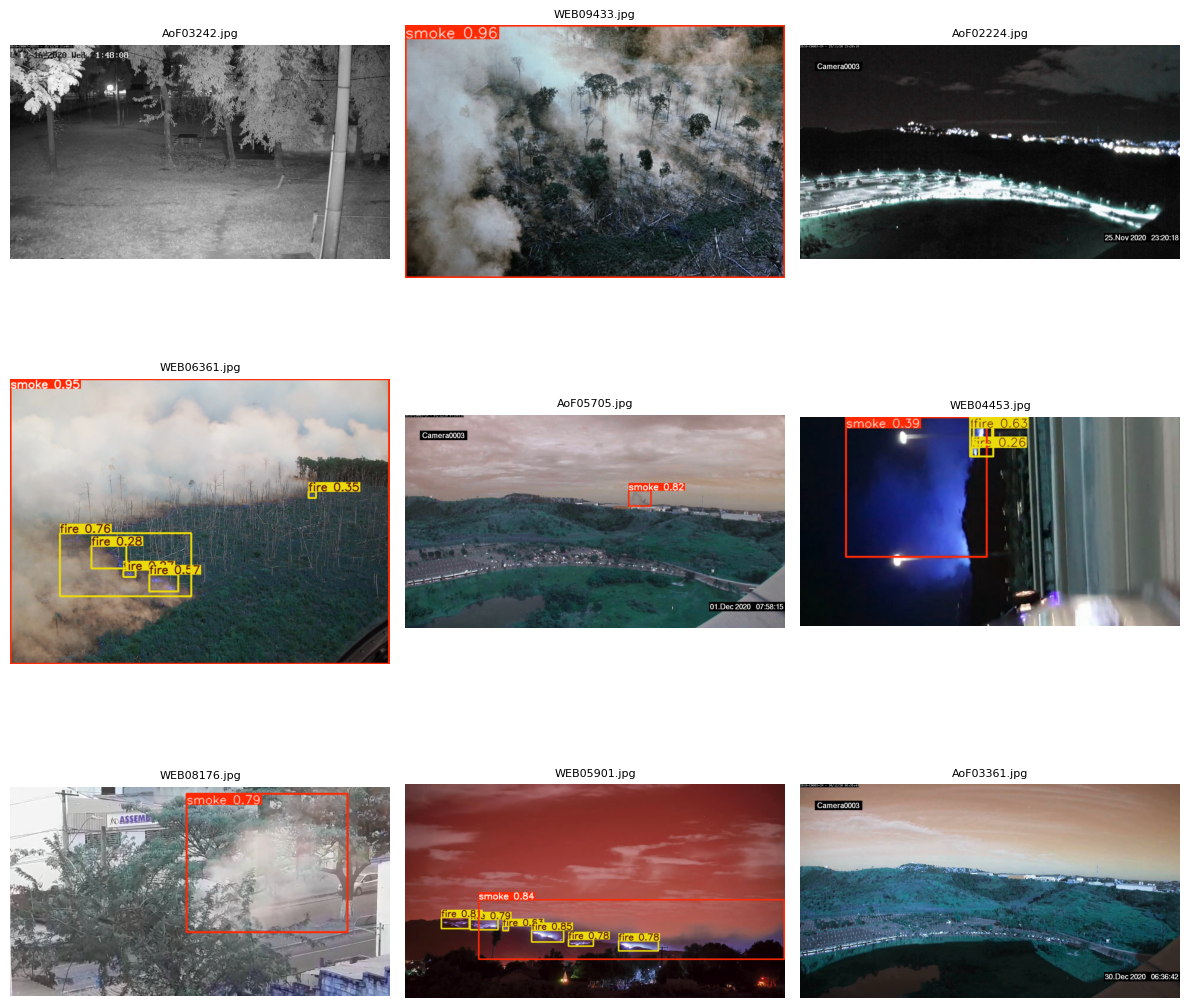

In [10]:
# 3x3 그리드 탐지 시각화 (bbox 포함)

val_img_dir = 'fire_smoke_detection/data/val/images'
val_lbl_dir = 'fire_smoke_detection/data/val/labels'

visualize_grid(model, val_img_dir, val_lbl_dir, rows=3, cols=3)

## 6. 테스트셋 평가 (mAP 등)

In [11]:
# 테스트 데이터셋에서 모델 평가 (mAP, precision, recall 등)
test_metrics = model.val(
    data=data_yaml,
    split='test',  # 테스트셋 평가
    batch=default_batch,   # 훈련에 사용한 batch와 동일하게 맞추기
    device=0,
    name='rtdetr_test_hyp',
    project='rtdetr_fire_smoke_hyp',
    verbose=True
)
print("\n[테스트셋 평가 결과]")
print(test_metrics)

Ultralytics 8.3.233 🚀 Python-3.10.18 torch-2.6.0+cu118 CUDA:0 (NVIDIA A100-PCIE-40GB, 40339MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1424.6±1168.9 MB/s, size: 209.6 KB)
val: Scanning /fire_smoke_detection/data/test/labels... 4306 images, 2005 backgrounds, 4 corrupt: 100% ━━━━━━━━━━━━ 4306/4306 1.2Kit/s 3.6s0.1ss
val: /fire_smoke_detection/data/test/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: /fire_smoke_detection/data/test/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: /fire_smoke_detection/data/test/images/WEB11243.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11244.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11245.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test

### 6-1. 탐지 결과 시각화 (bbox 포함)

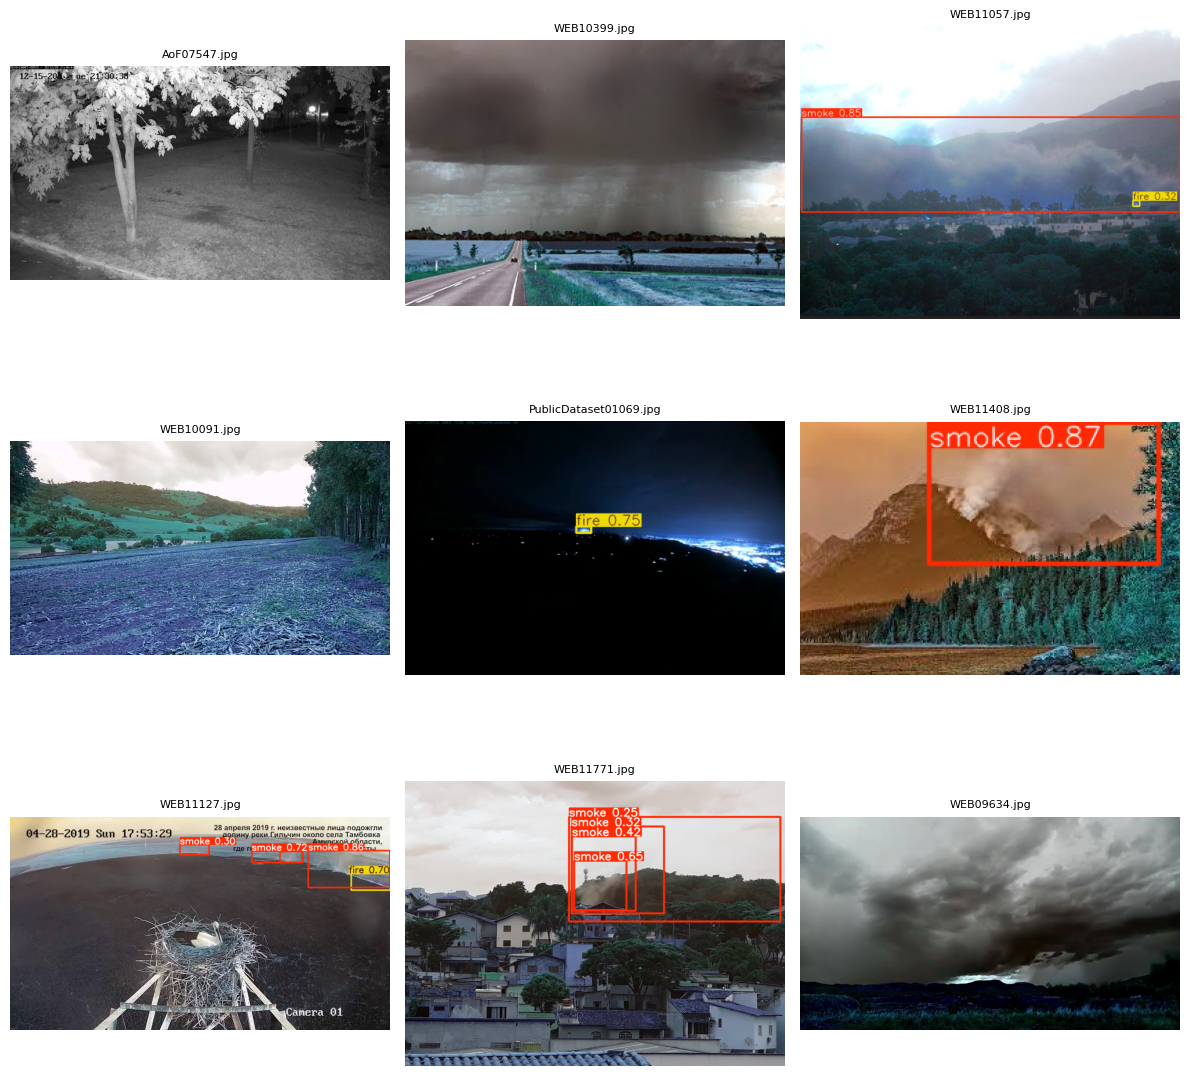

In [12]:
# 테스트셋 3x3 그리드 탐지 시각화 (bbox 포함)

test_img_dir = 'fire_smoke_detection/data/test/images'
test_lbl_dir = 'fire_smoke_detection/data/test/labels'

visualize_grid(model, test_img_dir, test_lbl_dir, rows=3, cols=3)

## 7. 기본학습 vs 하이퍼파라미터 학습 비교

두 실험의 `runs/train/.../results.csv`를 읽어 주요 지표(학습/검증 손실, mAP)를 비교합니다. 경로가 다르거나 폴더명이 다르면 아래 변수만 수정하세요.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 각 실험의 results.csv 경로 설정 (필요시 수정)
baseline_dir = r"runs\train\rtdetrv2"
hyp_dir = r"runs\train\rtdetrv2_hyp"

baseline_csv = os.path.join(baseline_dir, "results.csv")
hyp_csv = os.path.join(hyp_dir, "results.csv")

if not os.path.exists(baseline_csv):
    raise FileNotFoundError(f"Baseline results.csv not found: {baseline_csv}")
if not os.path.exists(hyp_csv):
    raise FileNotFoundError(f"Hyp results.csv not found: {hyp_csv}")

# CSV 로드
df_base = pd.read_csv(baseline_csv)
df_hyp = pd.read_csv(hyp_csv)

# 공통 에포크 인덱스 추정 (첫 컬럼이 'epoch'가 아닐 수 있어 인덱스를 사용)
epochs_base = range(1, len(df_base) + 1)
epochs_hyp = range(1, len(df_hyp) + 1)

# 비교할 컬럼들 (Ultralytics results.csv 기준으로 자주 쓰는 지표)
cols = {
    "train_box_loss": "box_loss",
    "train_cls_loss": "cls_loss",
    "train_dfl_loss": "dfl_loss",
    "val_box_loss": "val/box_loss",
    "val_cls_loss": "val/cls_loss",
    "val_dfl_loss": "val/dfl_loss",
    "mAP50-95": "metrics/mAP50-95",
    "mAP50": "metrics/mAP50",
}

# 2x2 혹은 3x3 레이아웃으로 그리기
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()
plot_idx = 0

for title, col in cols.items():
    ax = axes[plot_idx]
    if col in df_base.columns:
        ax.plot(epocs_base := list(epochs_base), df_base[col], label="baseline", color="tab:blue")
    else:
        ax.text(0.5, 0.5, f"{col} not in baseline", ha="center")

    if col in df_hyp.columns:
        ax.plot(epocs_hyp := list(epochs_hyp), df_hyp[col], label="hyp", color="tab:orange")
    else:
        ax.text(0.5, 0.4, f"{col} not in hyp", ha="center")

    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.grid(True, alpha=0.2)
    ax.legend()
    plot_idx += 1

# 남는 축 숨기기
for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

print("Compared:")
print(f"- Baseline: {baseline_csv}")
print(f"- Hyp:      {hyp_csv}")